In [ ]:
#For mount drive run this command
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Import the Libraries, using TensorFlow backend

In [ ]:
#import all library
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import random
import cv2
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
from sklearn.metrics import classification_report
from tensorflow.keras.regularizers import Regularizer
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Layer, Flatten, GlobalMaxPool2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import Input



editor='giacomo'


if editor == 'giacomo':
  path_training='/content/drive/MyDrive/Progetto_VISIOPE/Img/Training'
  path_testing='/content/drive/MyDrive/Progetto_VISIOPE/Img/Testing'


elif editor == 'francesco':
  path_training='/content/drive/MyDrive/Project_VP/archive/Training'
  path_testing='/content/drive/MyDrive/Project_VP/archive/Testing'

elif editor=='giuseppe':
  path_training='/content/drive/MyDrive/VISIOPE_PROJECT23/archive/Training'
  path_testing='/content/drive/MyDrive/VISIOPE_PROJECT23/archive/Testing'



print('Libraries imported')
print("Hello", editor, "have fun working on this project","\n", "Your TRAINING path is ", path_training, "\n", "Your TESTING path is ", path_testing)

Libraries imported
Hello giacomo have fun working on this project 
 Your TRAINING path is  /content/drive/MyDrive/Progetto_VISIOPE/Img/Training 
 Your TESTING path is  /content/drive/MyDrive/Progetto_VISIOPE/Img/Testing


## Dataset

In [ ]:
# Get Class Names
class_names = sorted(os.listdir(path_training))
n_classes = len(class_names)
print(f"Class Names: \n{class_names}")
print(f"Total Number of Classes : {n_classes}")

Class Names: 
['glioma', 'meningioma', 'notumor', 'pituitary']
Total Number of Classes : 4


In [ ]:
class_dis = [len(os.listdir(path_training + f"/{name}")) for name in class_names]
print(f"Class Distribution : \n{class_dis}")

Class Distribution : 
[1321, 1339, 1595, 1461]


In [ ]:
import plotly.express as px
fig = px.pie(names=class_names, values=class_dis, width=600)
fig.update_layout({"title":{'text':"Class Distribution","x":0.5}})
fig.show()

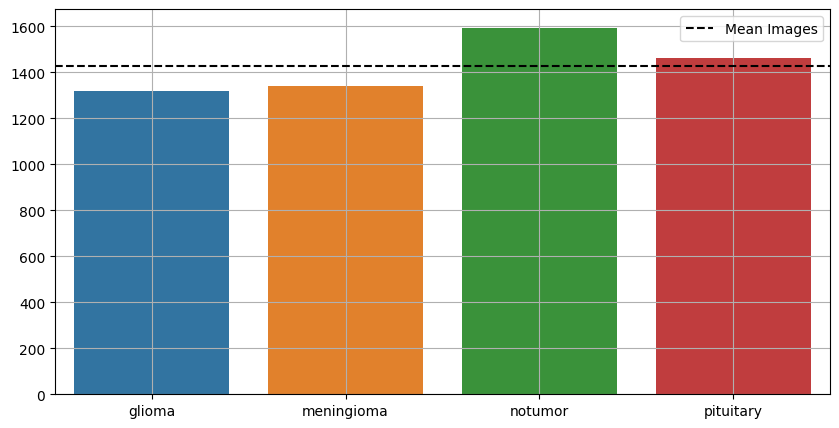

In [ ]:
import seaborn as sns

plt.figure(figsize=(10,5))
sns.barplot(x=class_names, y=class_dis)
plt.grid()
plt.axhline(np.mean(class_dis), color='k', linestyle='--', label="Mean Images")
plt.legend()
plt.show()

In [ ]:
data = {}
for root, _, filenames in os.walk(path_training):
    dirname = root.split('/')[-1]

    for filename in filenames:

        if dirname not in data.keys():
            data[dirname] = []

        data[dirname].append(os.path.join(root, filename))

###Random Samples of each class

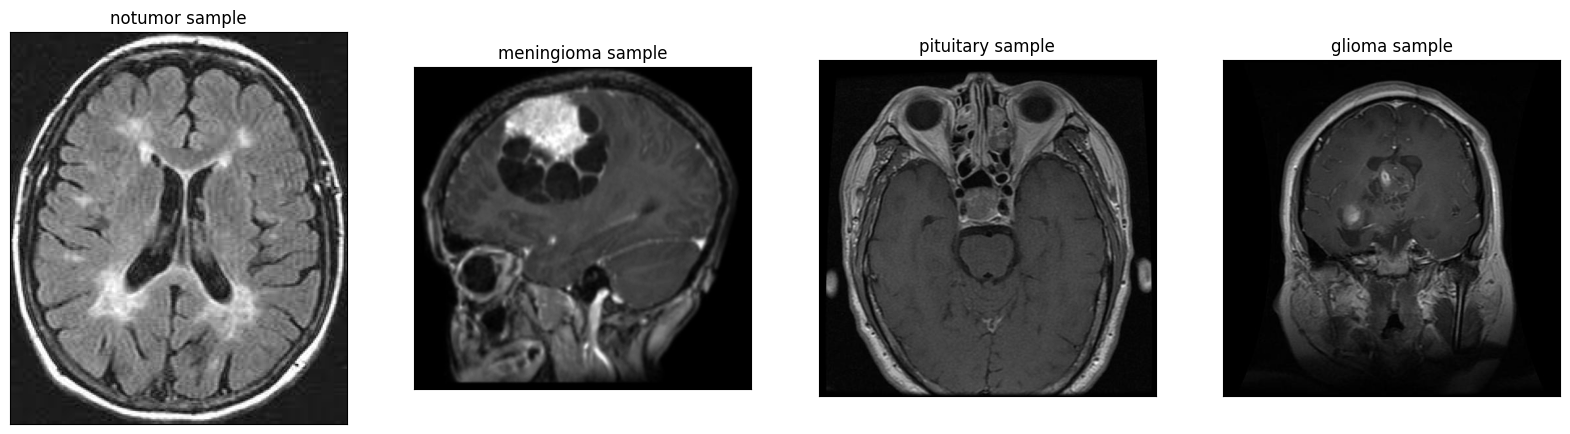

In [ ]:
plt.figure(figsize=(20, 20))

samples = []
for i, k in enumerate(data.keys()):
    s = cv2.imread(random.choice(data[k]))
    s = cv2.cvtColor(s, cv2.COLOR_BGR2GRAY)
    samples.append(s)

    plt.subplot(1, 4, i + 1)
    plt.imshow(samples[-1], cmap='gray')
    plt.title(k + ' sample')
    plt.xticks([])
    plt.yticks([])

###Grayscale hystogram of the images behind

x-axis: gray intensity


y-axis: number of pixel such intensity levels

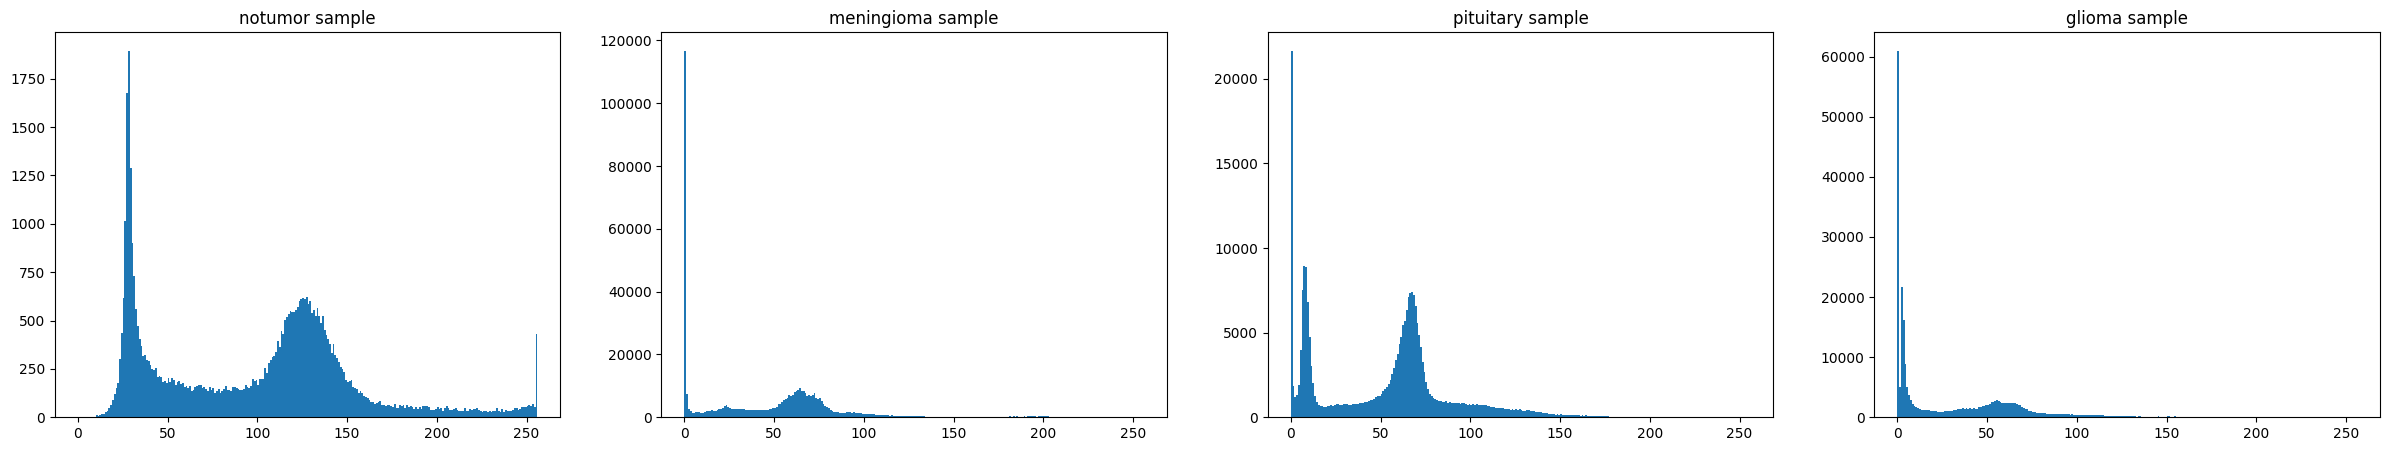

In [ ]:
plt.figure(figsize=(30, 5))

for i, s in enumerate(samples):
    plt.subplot(1, 4, i + 1)
    plt.hist(s.ravel(),256,[0,256])
    plt.title(list(data.keys())[i] + ' sample')

##Basic processing on the images

*   Canny




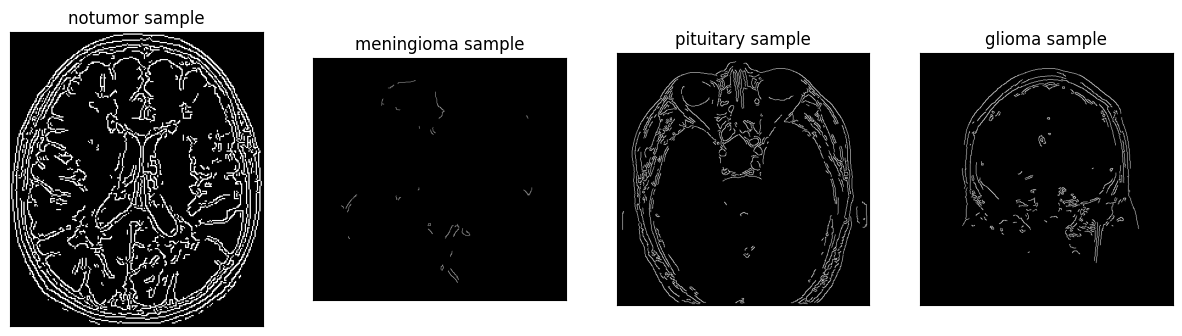

In [ ]:
plt.figure(figsize=(15, 15))

for i, s in enumerate(samples):
    s = cv2.Canny(s, threshold1=140, threshold2=210)

    plt.subplot(1, 4, i + 1)
    plt.imshow(s, cmap='gray')
    plt.title(list(data.keys())[i] + ' sample')
    plt.xticks([])
    plt.yticks([])

*   Sobel X -> to search the the gradient of the image in the horizontal axis
*   Sobel Y -> to search the the gradient of the image in the vertical axis
*   Laplacian
*   Blended

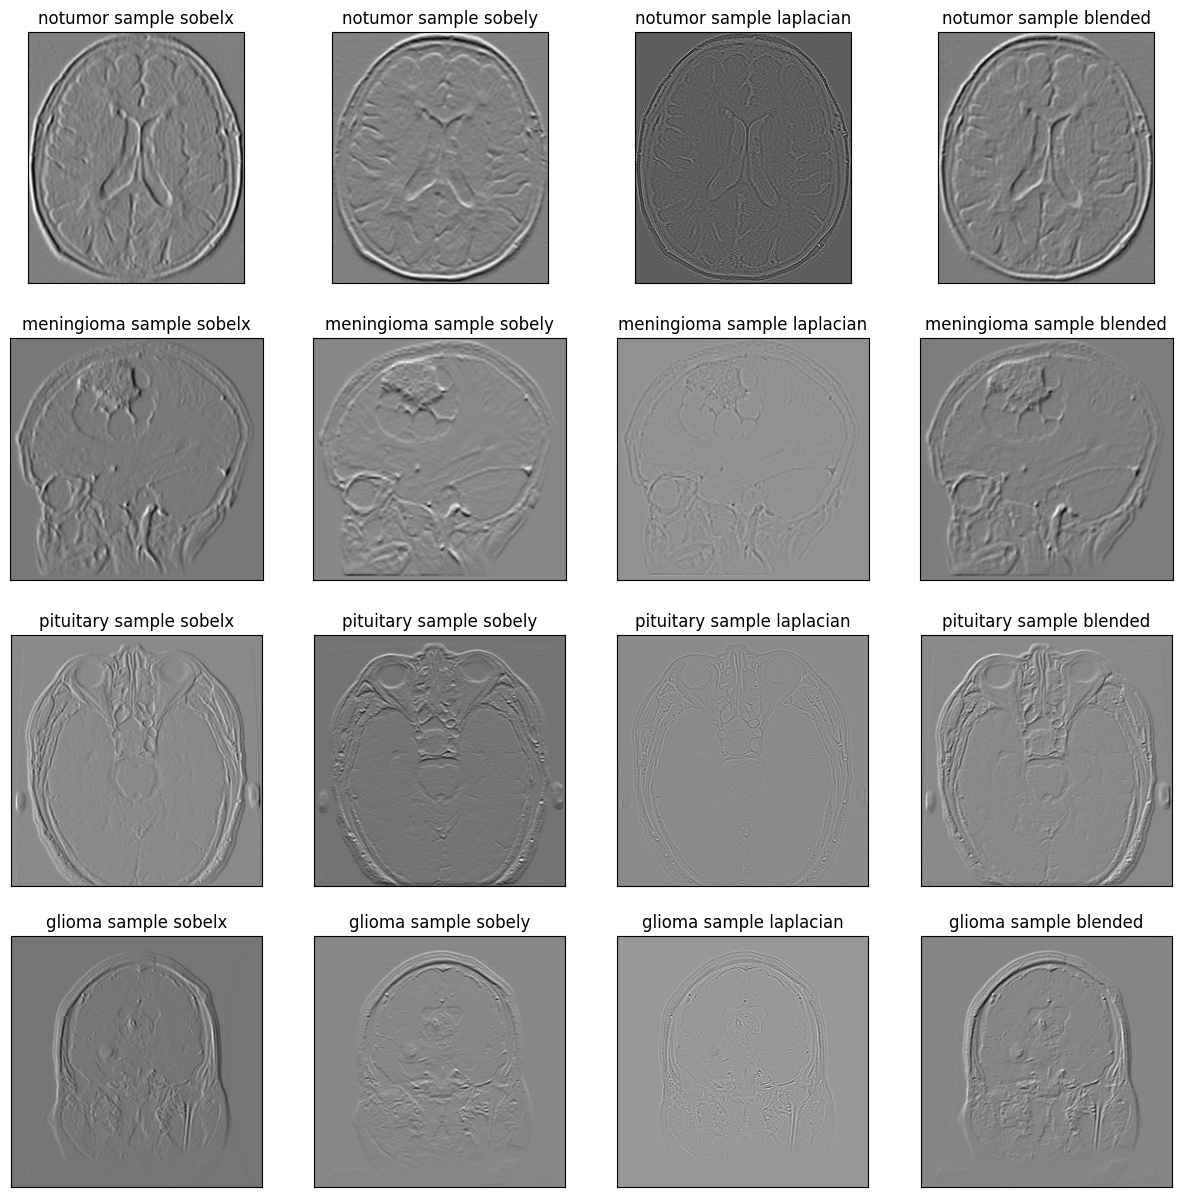

In [ ]:
plt.figure(figsize=(15, 15))

j = 0
for i, s in enumerate(samples):
    sobelx = cv2.Sobel(s, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(s, cv2.CV_64F, 0, 1, ksize=5)
    laplacian = cv2.Laplacian(s, cv2.CV_64F)
    blended = cv2.addWeighted(src1=sobelx, alpha=0.5, src2=sobely, beta=0.5,gamma=0)

    plt.subplot(4, 4, i + j + 1)
    plt.imshow(sobelx, cmap='gray')
    plt.title(list(data.keys())[i] + ' sample sobelx')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(4, 4, i + j + 2)
    plt.imshow(sobely, cmap='gray')
    plt.title(list(data.keys())[i] + ' sample sobely')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(4, 4, i + j + 3)
    plt.imshow(laplacian, cmap='gray')
    plt.title(list(data.keys())[i] + ' sample laplacian')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(4, 4, i + j + 4)
    plt.imshow(blended, cmap='gray')
    plt.title(list(data.keys())[i] + ' sample blended')
    plt.xticks([])
    plt.yticks([])

    j += 3

## Data Augmentation and Preprocessing

Generates batches of augmented data and Split the Data set

In [ ]:
img_size = 150
batch_size = 32

generator_train = ImageDataGenerator(rescale=1./255,
                                    rotation_range=20,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    shear_range=0.1,
                                    zoom_range=0.1,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    fill_mode="nearest")

generator_test = ImageDataGenerator(rescale=1./255)



train = generator_train.flow_from_directory(path_training,
                                            target_size=(img_size, img_size),
                                            batch_size=batch_size,
                                            class_mode='categorical')

test = generator_test.flow_from_directory(path_testing,
                                          target_size=(img_size, img_size),
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          shuffle=False)


Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


## Our CNN Model

Convolutional Neural Network Model

Model 1

In [ ]:
model = Sequential()

# Convolutional layer 1
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D(pool_size=(2,2)))

# Convolutional layer 2
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Convolutional layer 3
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Convolutional layer 3
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

# Feed Forward
model.add(Dense(units= 512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units= 4, activation='softmax'))


# Model Compilation
model.compile(optimizer=Adam(learning_rate= 0.001), loss='categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

Model Training

In [ ]:
#Regularization
early_stopping = EarlyStopping(monitor = 'val_loss', restore_best_weights=True, patience = 5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001)
checkpoint = ModelCheckpoint(filepath = 'model_weights.h5', monitor = 'val_loss', save_best_only = True)

history = model.fit(train, steps_per_epoch=178, validation_data=test, epochs= 50, validation_steps= 1311/32, callbacks=[early_stopping, reduce_lr, checkpoint])

Epoch 1/50
178/178 [==============================] - 2636s 15s/step - loss: 1.0257 - accuracy: 0.5450 - val_loss: 1.1861 - val_accuracy: 0.5728 - lr: 0.0010
Epoch 2/50
178/178 [==============================] - 69s 387ms/step - loss: 0.7617 - accuracy: 0.7029 - val_loss: 1.4256 - val_accuracy: 0.5217 - lr: 0.0010
Epoch 3/50
178/178 [==============================] - 66s 373ms/step - loss: 0.7023 - accuracy: 0.7208 - val_loss: 0.8731 - val_accuracy: 0.6690 - lr: 0.0010
Epoch 4/50
178/178 [==============================] - 69s 391ms/step - loss: 0.6533 - accuracy: 0.7412 - val_loss: 1.3873 - val_accuracy: 0.5217 - lr: 0.0010
Epoch 5/50
178/178 [==============================] - 70s 395ms/step - loss: 0.5840 - accuracy: 0.7681 - val_loss: 1.4013 - val_accuracy: 0.5469 - lr: 0.0010
Epoch 6/50
178/178 [==============================] - 65s 368ms/step - loss: 0.5458 - accuracy: 0.7876 - val_loss: 0.8276 - val_accuracy: 0.7147 - lr: 0.0010
Epoch 7/50
178/178 [==============================] 

## INCEPTION MODEL

Model 2

In [ ]:
#pre trained model
incv3= InceptionV3(include_top = False, weights='imagenet', input_shape=(150,150,3))

for layer in incv3.layers:
    layer.trainable = False
# Set the last vgg block to trainable
incv3.layers[-2].trainable = True
incv3.layers[-3].trainable = True

model= Sequential()

model.add(Input(shape=(img_size,img_size,3)))
model.add(incv3)
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(512, activation= 'relu'))
model.add(Dropout(0.2))
model.add(Dense(4, activation= 'softmax'))

model.compile(optimizer=Adam(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 flatten_1 (Flatten)         (None, 18432)             0         
                                                                 
 dropout_2 (Dropout)         (None, 18432)             0         
                                                                 
 dense_2 (Dense)             (None, 512)               9437696   
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 31,242,532
Trainable params: 9,439,748
N

Inception Training

In [ ]:
#Regularization
early_stopping = EarlyStopping(monitor = 'val_loss', restore_best_weights=True, patience = 5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)
checkpoint = ModelCheckpoint(filepath = 'model_weights.h5', monitor = 'val_loss', save_best_only = True)

history = model.fit(train, steps_per_epoch=5712/32, validation_data=test, epochs= 30, validation_steps= 1311/32, callbacks=[early_stopping, reduce_lr, checkpoint])

Epoch 1/30
178/178 [==============================] - 1335s 7s/step - loss: 2.4473 - accuracy: 0.7174 - val_loss: 0.7101 - val_accuracy: 0.7269 - lr: 0.0010
Epoch 2/30
178/178 [==============================] - 254s 1s/step - loss: 0.5154 - accuracy: 0.8016 - val_loss: 0.5330 - val_accuracy: 0.7986 - lr: 0.0010
Epoch 3/30
178/178 [==============================] - 292s 2s/step - loss: 0.4710 - accuracy: 0.8181 - val_loss: 0.4754 - val_accuracy: 0.8078 - lr: 0.0010
Epoch 4/30
178/178 [==============================] - 296s 2s/step - loss: 0.4514 - accuracy: 0.8258 - val_loss: 0.4679 - val_accuracy: 0.8169 - lr: 0.0010
Epoch 5/30
178/178 [==============================] - 257s 1s/step - loss: 0.4324 - accuracy: 0.8328 - val_loss: 0.4482 - val_accuracy: 0.8131 - lr: 0.0010
Epoch 6/30
178/178 [==============================] - 260s 1s/step - loss: 0.4172 - accuracy: 0.8377 - val_loss: 0.4170 - val_accuracy: 0.8299 - lr: 0.0010
Epoch 7/30
178/178 [==============================] - 293s 2s/s

Save the model

In [ ]:
model.save('/content/drive/MyDrive/Project_VP/IncV3_tumor.model')

Load the model (for evaluation)

In [ ]:
#load saved model
model = tf.keras.models.load_model('/content/drive/MyDrive/Project_VP/Brain_tumor.model') ##CAMBIA

##Results of the training

Graph of Accuracy

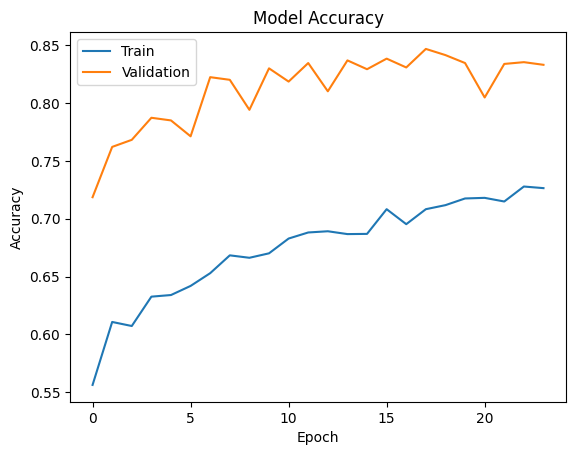

In [ ]:
# Graphs of Training and Validation Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

Validation Loss

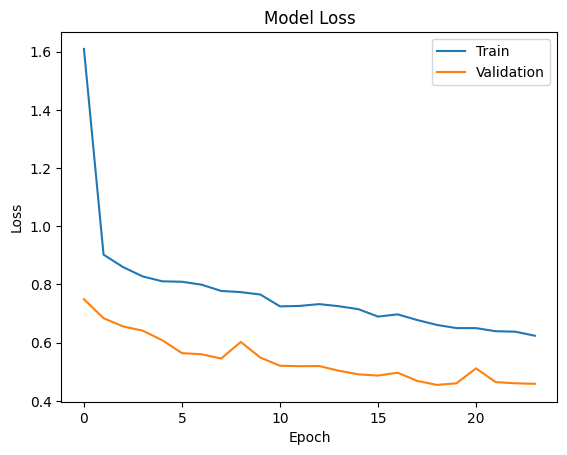

In [ ]:
# Graphs of Training and Validation Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

##Evaluation

Evaluation of the Model

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(test, steps=1311/batch_size)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

40/40 [==============================] - 6s 136ms/step - loss: 0.4549 - accuracy: 0.8413
Test Loss: 0.45489028096199036
Test Accuracy: 0.8413425087928772


##Predict


In [ ]:
# Make predictions on the test dataset
y_val = test.classes
y_pred = model.predict(test)
y_pred = np.argmax(y_pred,axis=1)

41/41 [==============================] - 6s 114ms/step


In [ ]:
print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support

           0       0.92      0.71      0.80       300
           1       0.65      0.77      0.71       306
           2       0.95      0.94      0.94       405
           3       0.86      0.92      0.89       300

    accuracy                           0.84      1311
   macro avg       0.85      0.83      0.83      1311
weighted avg       0.85      0.84      0.84      1311



Create Dataframe with Predict

In [ ]:
class_indices = test.class_indices
indices = {v:k for k,v in class_indices.items()}

In [ ]:
filenames = test.filenames

In [ ]:
val_df = pd.DataFrame()
val_df['filename'] = filenames
val_df['actual'] = y_val
val_df['predicted'] = y_pred
val_df['actual'] = val_df['actual'].apply(lambda x: indices[x])
val_df['predicted'] = val_df['predicted'].apply(lambda x: indices[x])
val_df.loc[val_df['actual']==val_df['predicted'],'Same'] = True
val_df.loc[val_df['actual']!=val_df['predicted'],'Same'] = False
val_df.head(10)

,filename,actual,predicted,Same
0,glioma/Te-glTr_0000.jpg,glioma,glioma,True
1,glioma/Te-glTr_0001.jpg,glioma,glioma,True
2,glioma/Te-glTr_0002.jpg,glioma,glioma,True
3,glioma/Te-glTr_0003.jpg,glioma,meningioma,False
4,glioma/Te-glTr_0004.jpg,glioma,glioma,True
5,glioma/Te-glTr_0005.jpg,glioma,meningioma,False
6,glioma/Te-glTr_0006.jpg,glioma,glioma,True
7,glioma/Te-glTr_0007.jpg,glioma,glioma,True
8,glioma/Te-glTr_0008.jpg,glioma,glioma,True
9,glioma/Te-glTr_0009.jpg,glioma,glioma,True


In [ ]:
val_df = val_df.sample(frac=1).reset_index(drop=True)

##Prediction

*   Correctly Classified (A and P are same)
*   Misclassified (A and P are different)
*   A: Actual P: Predicted

In [ ]:
def readImage(path):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.

    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
        image = readImage(f"/content/drive/MyDrive/Project_VP/archive/Testing/{temp_df.filename[i]}")
        plt.imshow(image)
        plt.title(f'A: {temp_df.actual[i]} P: {temp_df.predicted[i]}')

Correctly classified

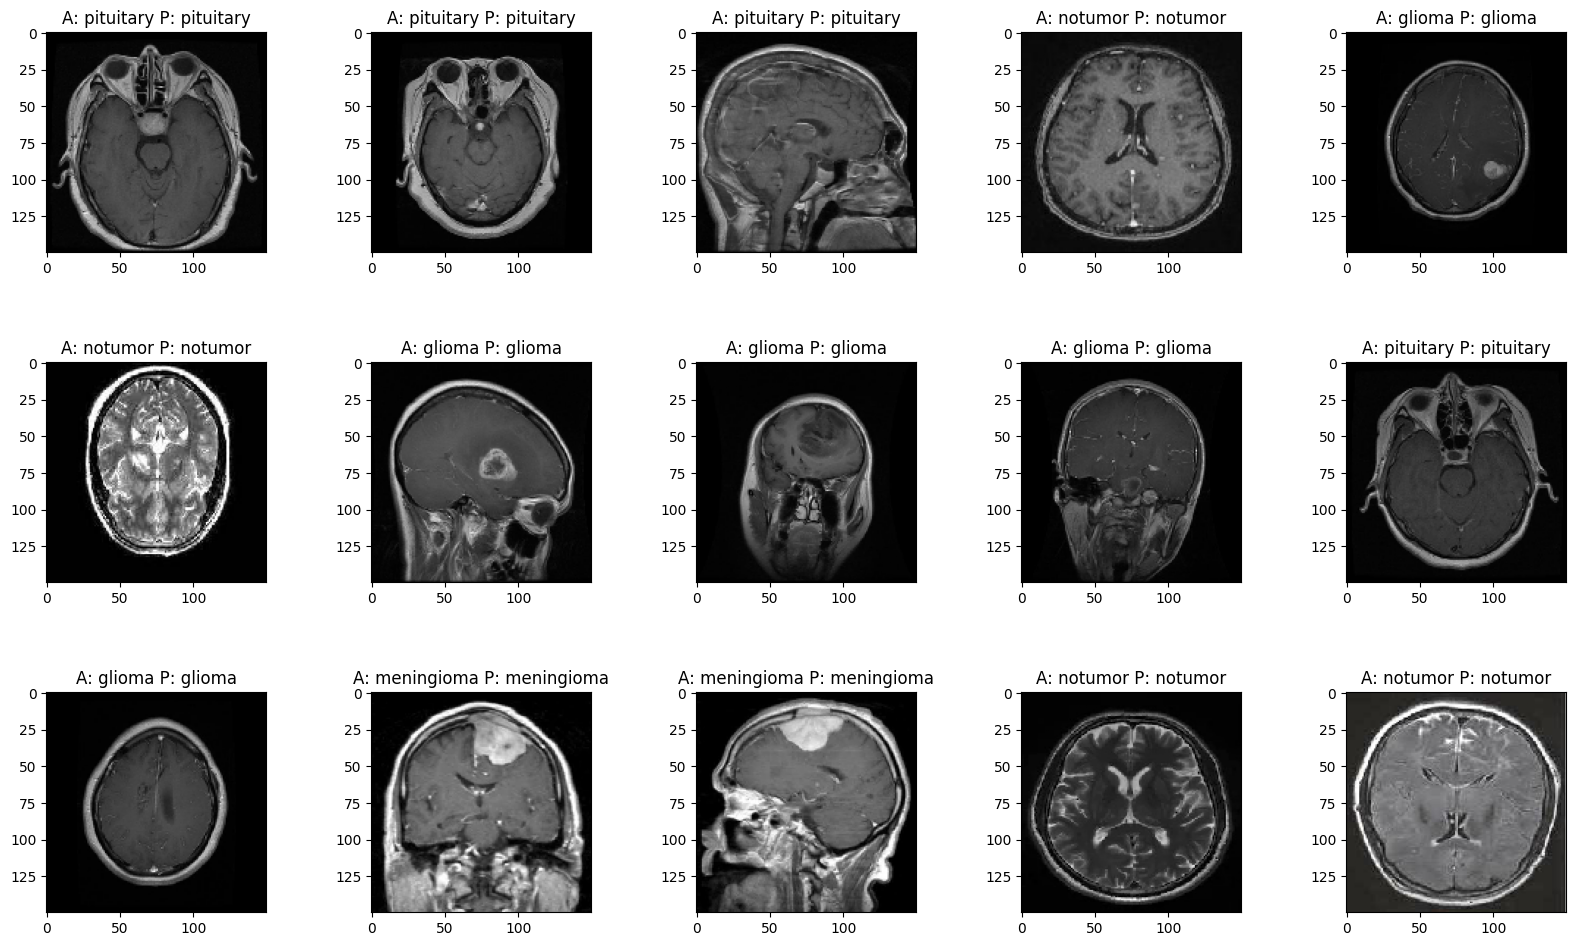

In [ ]:
display_images(val_df[val_df['Same']==True])

Misclassified

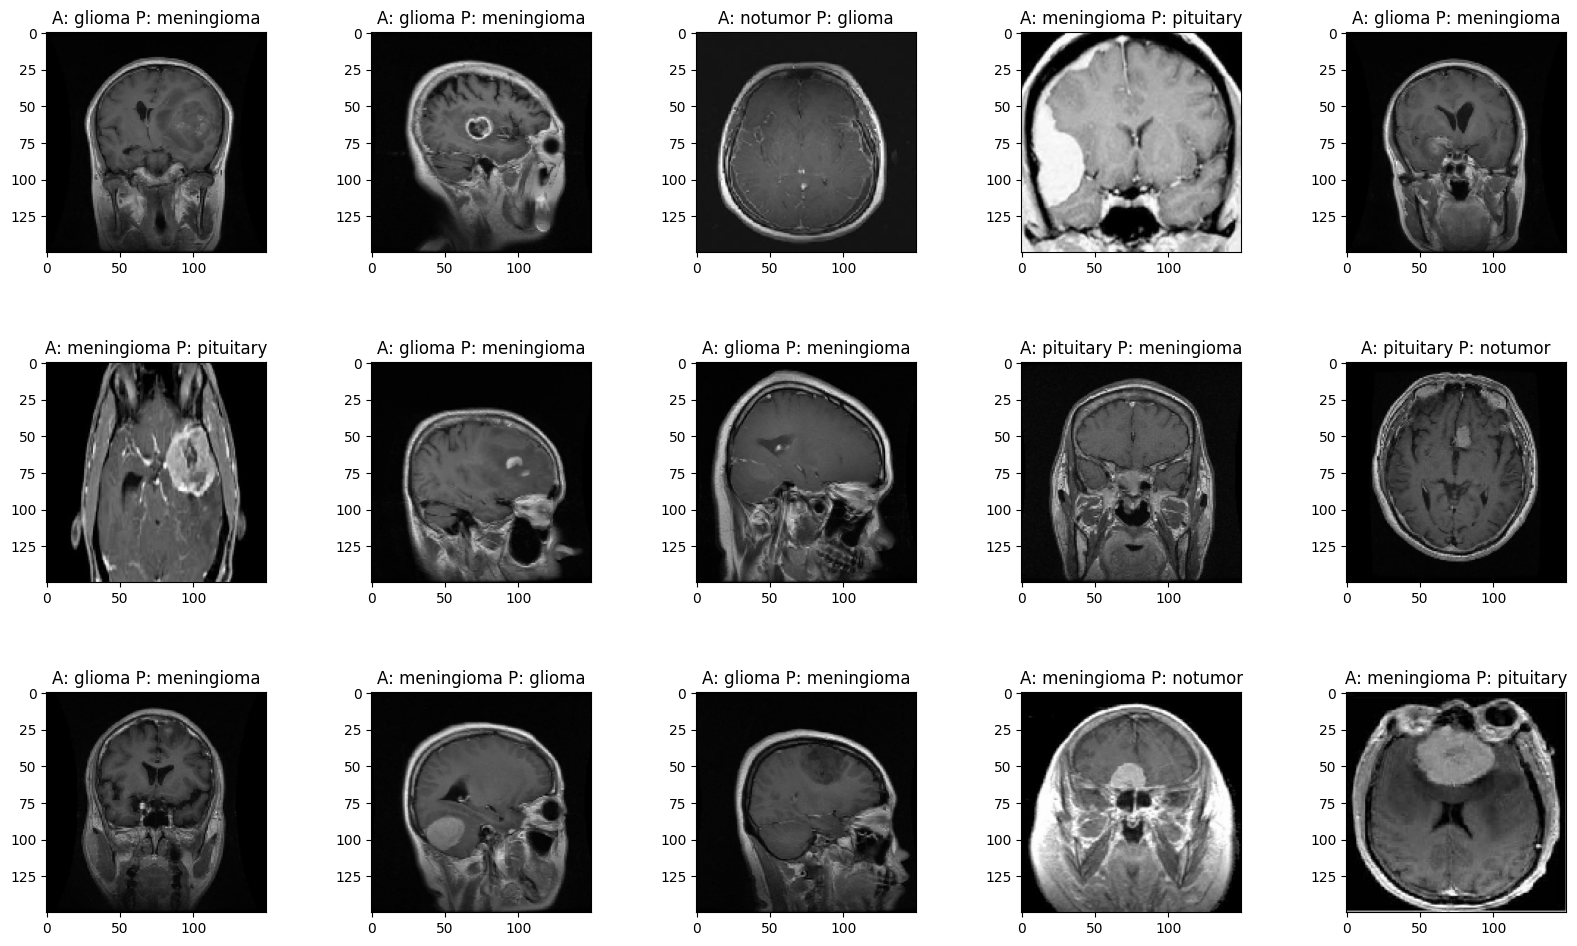

In [ ]:
display_images(val_df[val_df['Same']!=True])

###Confusion matrix and Predict


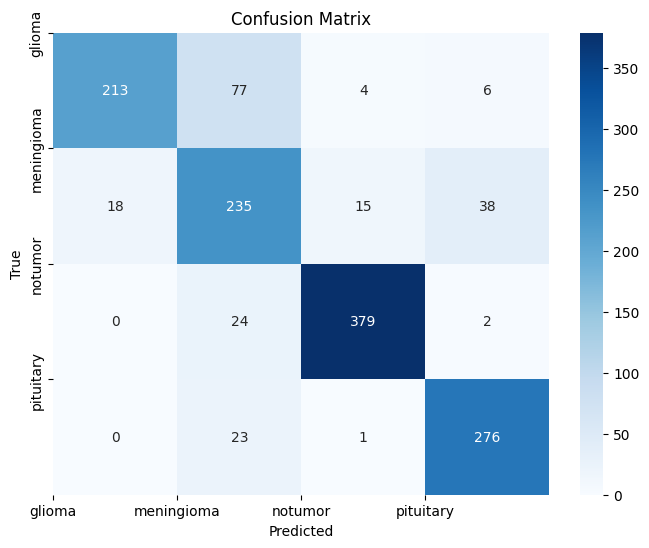

In [ ]:
categories = ["glioma", "meningioma", "notumor", "pituitary"]

# Create a confusion matrix
confusion_matrix = tf.math.confusion_matrix(y_val, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(len(categories)), labels=categories)
plt.yticks(ticks=np.arange(len(categories)), labels=categories)
plt.show()